## ABSTRACT

This is the code related to the article presenting <b>the methodology IKE-XAI for Implicit Knowledge Extraction with eXplainable Artificial Intelligence</b> from the article. We use the <b>Tower of Hanoï (TOH)</b> as a guiding showcase of the proposed IKE-XAI methodology<br/> 
<b>[Chraibi Kaadoud et al, 2022]</b> Ikram Chraibi Kaadoud, Adrien Bennetot,Barbara Mawhin, Vicky Charisi, Natalia Díaz-Rodríguez, Explaining Aha! moments in artificial agents through IKE-XAI: Implicit Knowledge Extraction for eXplainable AI, Neural Networks, 2022.

<p align = "center">
<img src="Figures/ExperimentalDesign.png" alt="drawing" width="700"/>
</p>
<p align = "center">
    <b>Figure 2 of Chraibi Kaadoud et al (2022):</b> Experimental design of the IKE-XAI methodology to make explicit the process of the autonomous agent (AA) knowledge construction in three steps:<br/>
<b>STEP 1) RL Phase:</b> a Q-learning agent learns to perform the TOH task. At several stages of the learning process,
the training process is suspended to make a recording of the AA’s move sequences while it plays after learning. This step obtains: a) sequences of moves and b) an AA trained to perform TOH whose behavior is observable through its sequences of moves, to inform the solution chosen by the AA to reach the solution state (i.e., sequences of moves).<br/>
<b>STEP 2) Moves Sequence Learning Phase:</b> the recorded sequences of moves of the AA are fed to train an LSTM
to predict the AA’s next move at time t based on the current and past ones. This step returns a dataset of recordings of hidden patterns (i.e, the activity vectors of the hidden layer generated by the network at each input). The trained LSTM model had encoded an implicit representation of the TOH rules due to the learned sequences. Let us note that the trained LSTM model is trained on sequences generated from the TOH abstract representation (Figure B.13). <br/>
<b>STEP 3) XAI Phase:</b> a post-hoc implicit rule extraction algorithm and a graph visualization technique are applied
to the dataset of recorded hidden patterns to extract graphs of AA behavior at different stages of training.
</p>


The current notebook present the main steps of the IKE-XAI methodology. <br/>
A breif presentation of the TOH task is provided in <b>[Chraibi Kaadoud et al, 2022] appendix B</b>


#### Installation of requirements


In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install networkx
!pip install pydot
!pip install tensorflow
!pip install simplejson
!pip install scikit-learn==1.0.1

## STEP 1 - Train the Q learning Artificial Agent (AA) on TOH task

The RL Phase consists in training a Q-learning agent to perform the TOH task. At several stages of the learning process, the training process is suspended to make a recording of the AA’s move sequences while it plays after learning. <br/>
This step obtains: <br/>
<b>a)</b> sequences of moves <br/> 
<b>b)</b> an AA trained to perform TOH whose behavior is observable through its sequences of moves, to inform the solution chosen by the AA to reach the solution state (i.e., sequences of moves).<br/>

In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import random
import tools
import os
from os import path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

#### Declaration of all functions for step 1

In [2]:

class TowersOfHanoi:
    def __init__(self, state):
        # "State" is a tuple of length N, where N is the number of discs, and the elements are peg indices in [0,1,2]
        self.state = state               
        self.discs = len(self.state)

    def discs_on_peg(self, peg):
        return [disc for disc in range(self.discs) if self.state[disc] == peg]

    def move_allowed(self, move):
        discs_from = self.discs_on_peg(move[0])
        discs_to = self.discs_on_peg(move[1])
        if discs_from:
            return (min(discs_to) > min(discs_from)) if discs_to else True
        else:
            return False

    def get_moved_state(self, move):
        if self.move_allowed(move):
            disc_to_move = min(self.discs_on_peg(move[0]))
        moved_state = list(self.state)
        moved_state[disc_to_move] = move[1]
        moved_state_t= tuple(moved_state)
        return moved_state_t


def generate_grammar_from_df(N, R,G,result_dir_for_N_disks, debug=False):
    df_R = R.replace(0, 1)
    df_R = df_R.replace(-np.inf, 0)
    if debug:
        print("type(df_R) : ", type(df_R))
        print("df_R : ", df_R)
        print(" df_R column : ", df_R.columns)
        print(" df_R rows : ", df_R.index)

    df_cols_tuple = df_R.columns.tolist()
    df_cols = [str(x) for x in df_cols_tuple]

    toh_grammar={}
    for i in range(len(df_R.columns)):
        node = str(df_R.columns[i])
        if debug : print("\n node : ", node)
        list_transitions=[]
        for one_neighbor in G.neighbors(node):
            index_one_neighbor= list(df_cols).index(one_neighbor)
            diff = ""
            assert(len(node)==len(one_neighbor))
            for t in range(len(node)):
                if node[t] != one_neighbor[t]:
                    diff = str(node[t]) + "-" + str(one_neighbor[t])
            tuple=(diff, index_one_neighbor)
            list_transitions.append(tuple)
            if debug : print(" =====>one_neighbor : ", one_neighbor, " -  diff : ", diff)

        toh_grammar[i]={"transitions": list_transitions, "label":node.replace(" ","").replace(",","").replace("(","").replace(")","")}

    if debug : print ("toh_grammar : ", toh_grammar)
    res_file =  result_dir_for_N_disks+"/TOH_"+str(N)+"_disks_grammar.json"
    tools.save_dict_in_json(toh_grammar,res_file)
    print("TOH grammar with, ",str(N), "disks saved in :" ,res_file)
    return toh_grammar

def generate_graph_from_reward_matrix(N,R, result_dir_for_N_disks,debug=False):
    from networkx.drawing.nx_agraph import graphviz_layout
    from networkx.drawing.nx_agraph import write_dot

    #1) transform the reward matrix into a numpy array matrices with 0 and 1 that represents the links between the states so that
    #we can plot a graph from it to visualize the links
    df_R =  R.replace(0, 1)
    df_R = df_R.replace(-np.inf, 0)

    if debug:
        print ("type(df_R) : ", type(df_R))
        print ("df_R : ", df_R)
        print(" df_R column : ", df_R.columns)
        print(" df_R rows : ", df_R.index)

    G = nx.Graph()
    labels = {}
    for i in range(len(df_R.columns)):
        a_col= str(df_R.columns[i])
        labels[str(a_col)]= a_col


    for i in range(len(df_R.columns)) :
        if debug: print("i : ", i, " -df_R.columns[i] :  ",df_R.columns[i])
        for j in range(len(df_R.index)):
            if debug :
                print("j : ", j, " -df_R.index[j] :  ",df_R.index[j])
                print("df_R[df_R.columns[i]] : ", df_R[df_R.columns[i]])
            cell_val = df_R.iat[i,j]
            if cell_val>0:

                src_node = str(df_R.columns[i])
                target_node = str(df_R.index[j])
                G.add_node(src_node, label=src_node)
                G.add_node(target_node, label=target_node)
                G.add_edge(src_node, target_node)

    plt.figure(figsize=(15, 8))

    nx.draw(G)
    labels = nx.draw_networkx_labels(G, pos=nx.spring_layout(G))
    plt.tight_layout()
    plt.axis("off")
    res_file = result_dir_for_N_disks+"/TOH_"+str(N)+"_disks_rules.png"
    plt.savefig(res_file)
    print("TOH representation with "+str(N)+" disks saved : ", res_file)

    if debug:
        print("G.nodes(data=True)) : ", G.nodes(data=True))
        print("G.nodes()) : ", G.nodes())
        print("G.edges(data=True) : ", G.edges(data=True))
        print ("labels : ", labels)


    return G

# Generates the reward matrix for the Towers of Hanoi game as a Pandas DataFrame
def generate_reward_matrix(N, debug=False):      # N is the number of discs

    states = list(itertools.product(list(range(1,4)), repeat=N))
    moves = list(itertools.permutations(list(range(1,4)), 2))
    R = pd.DataFrame(index=states, columns=states, data=-np.inf)
    for state in states:
        tower = TowersOfHanoi(state=state)
        for move in moves:
            if tower.move_allowed(move):
                next_state = tower.get_moved_state(move)
                R[state][next_state] = 0
    final_state = tuple([2]*N)          # Define final state as all discs being on the last peg
    R[final_state] += 100               # Add a reward for all moves leading to the final state

    if debug:
        print("states : ", states)
        print("moves : ", moves)
        print("R all : ", R)

    return R, R.values, states, moves

# Learn the Q matrix
def learn_Q(R, gamma=0.8, alpha=1.0, N_episodes=1000, random=False):
    ##a learning rate α = 1, a discount factor γ = 0.8
    Q = np.zeros(R.shape)
    states=list(range(R.shape[0]))
    for n in range(N_episodes):
        Q_previous = Q
        state = np.random.choice(states)                # Randomly select initial state
        next_states = np.where(R[state,:] >= 0)[0]      # Generate a list of possible next states
        next_state = np.random.choice(next_states)      # Randomly select next state from the list of possible next states
        V = np.max(Q[next_state,:])                     # Maximum Q-value of the states accessible from the next state
        if random==False:
            Q[state, next_state] = (1-alpha)*Q[state, next_state] + alpha*(R[state, next_state] + gamma*V)      # Update Q-values
    if np.max(Q) > 0:
        Q /= np.max(Q)      # Normalize Q to its maximum value
    return Q

#Get the policy for each states
def get_policy(Q, R):
    Q_allowed = pd.DataFrame(Q)[pd.DataFrame(R) >= 0].values
    #print("Q_allowed : ",Q_allowed)
    #print("Q_allowed.shape[0] : ",Q_allowed.shape[0])
    policy = []
    for i in range(Q_allowed.shape[0]):
        #print("\n i : ", i)
        row = Q_allowed[i,:]
        #print("row : ", row)
        sorted_vals = np.sort(row)
        sorted_vals = sorted_vals[~np.isnan(sorted_vals)][::-1]
        #print("sorted_vals : ",sorted_vals)
        sorted_args = row.argsort()[np.where(~np.isnan(sorted_vals))][::-1]
        #print("sorted_args : ", sorted_args)
        max_vals = [val for val in sorted_vals if val==sorted_vals[0]]
        #print("max_vals : ", max_vals)
        max_args = [sorted_args[i] for i,val in enumerate(sorted_vals) if val==sorted_vals[0]]
        #print("max_args : ", max_args)
        policy.append(max_args)
        best_policy_value = max_vals[0]
    return policy, best_policy_value

#Play the defined policy
def play(policy, allowed, epsilon=0, last_move=100, debug=False):

    start_state = 0
    end_state = len(policy)-1
    state = start_state
    moves = 0
    number_asked = 0
    ask_for_help = False

    seq_states=[]
    seq_states.append(state)
    while state != end_state:
        if last_move < 3:
            test_eps = 100
        else:
            test_eps = random.uniform(0, 1)
        
        if test_eps < epsilon:
            state = np.random.choice(allowed[state])
        else:
            state = np.random.choice(policy[state])
        moves += 1

        seq_states.append(state)
        #to avoid having verry long sequences, we set a threshold to 10000 moves
        #We advise to rise this number according the value of N disks since the bigger is N, the longer are the sequences
        if moves > 10000:
            print("Maximal number of moves reached: ", moves)
            break


    if debug :
        print("play")
        print("len(seq_states) : ", len(seq_states))
        print("seq_states : ",seq_states)
    return moves, number_asked,seq_states

def play_average(policy, allowed, play_times=100, 
                 epsilon=0, debug=False):

    moves = np.zeros(play_times)
    seq_states = {}
    number_asked = np.zeros(play_times)
    if debug :
        print("play_average")
        print("allowed : ", allowed)
        print("moves : ", moves)

    for n in range(play_times):
        if debug : print("\n PLAY_TIME n° : ", n)
        last_move = np.mean(moves)                
        moves[n], number_asked[n],seq_states[n] = play(policy, allowed,epsilon, last_move)

    if debug : print("moves with update : ", moves)
    return np.mean(moves), np.std(moves), np.mean(number_asked), np.std(number_asked), seq_states

def Q_performance(R, episodes, play_times=100, 
                  random=False, epsilon=0,debug=False):
    if debug : print("\n\n Q_performance-------------------------------------")
    means = np.zeros(len(episodes))
    seq_states = {}
    stds = np.zeros(len(episodes))
    asked = np.zeros(len(episodes))
    asked_stds = np.zeros(len(episodes))
    for n, N_episodes in enumerate(episodes):
        if debug: print(" ==> Training session :", n, " - N_episodes : ", N_episodes)
        Q = learn_Q(R, N_episodes = N_episodes, random=random)
        policy, best_policy_value = get_policy(Q,R)
        if debug:
            print("n :", n, " - N_episodes : ", N_episodes)
            print("policy : ", policy, " - best_policy_value : ", best_policy_value)
        if n == 0:
            allowed, best_policy_value = get_policy(Q,R)
        means[n], stds[n], asked[n], asked_stds[n],seq_states[n] = play_average(policy, allowed, play_times, epsilon, debug)


    return means, stds, asked, asked_stds,seq_states

#Calculate the average Q learning performance
def Q_performance_average(R, episodes, learn_times = 100, play_times=100, 
                          random=False, 
                          epsilon=0,
                          debug=False):
    if debug : print("Q_performance_average")
    means_times = np.zeros((learn_times, len(episodes)))
    seq_states = {}
    stds_times = np.zeros((learn_times, len(episodes)))
    asked_times = np.zeros((learn_times, len(episodes)))
    asked_stds_times = np.zeros((learn_times, len(episodes)))
    for n in range(learn_times):
        print(" learn time : ", n)                                                     
        means_times[n,:], stds_times[n,:], asked_times[n,:], asked_stds_times[n,:], seq_states[n]  = Q_performance(R, episodes, play_times=play_times,
                                                                                                                   random=random, 
                                                                                                                   epsilon=epsilon) 
    means_averaged = np.mean(means_times, axis = 0)
    stds_averaged = np.mean(stds_times, axis = 0)
    asked_averaged = np.mean(asked_times, axis = 0)
    asked_stds_averaged = np.mean(asked_stds_times, axis = 0)
    return means_averaged, stds_averaged,seq_states



def plot_Qlearning_average_number_of_moves(N, episodes,means_averaged,stds_averaged, result_dir):
    fig = plt.figure()
    optimum_moves = 2 ** N - 1
    plt.plot(episodes, means_averaged, 'b-', linewidth=2, label='Average Performance')
    plt.plot(episodes, means_averaged + stds_averaged, 'b-', alpha=0.5)
    plt.plot(episodes, means_averaged - stds_averaged, 'b-', alpha=0.5)
    plt.fill_between(episodes, means_averaged - stds_averaged, means_averaged + stds_averaged, facecolor='blue',
                     alpha=0.5)
    plt.axhline(y=optimum_moves, color='g', label='Optimum')
    plt.xlabel('Number of training episodes')
    plt.ylabel('Number of moves')
    plt.grid('on', which='both')
    plt.title('Q-learning - Towers of Hanoi game with %s discs' % N)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, fontsize=10)
    res_file = result_dir+ "/TOH_"+str(N)+"_disks_average_number_of_moves.png"
    plt.savefig(res_file)
    plt.show()



#Prepare the final plot

def prepare_plot(episodes, N):
    fig = plt.figure()
    optimum_moves = 2**N - 1
    plt.axhline(y=optimum_moves, color='g', label='Optimum (=%s moves)' % optimum_moves)
    plt.xlabel('Number of training episodes')
    plt.ylabel('Number of moves')
    plt.grid('on', which='both')
    plt.title('Q-learning of the Towers of Hanoi game with %s discs' % N)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels)

def prepare_plot_aksed(episodes, N):
    fig = plt.figure()
    optimum_moves = 2**N - 1
    plt.axhline(y=optimum_moves, color='g', label='Optimum (=%s moves)' % optimum_moves)
    plt.xlabel('Number of training episodes')
    plt.ylabel('Number of asked for help')
    plt.grid('on', which='both')
    plt.title('Q-learning of the Towers of Hanoi game with %s discs' % N)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels)

#Plot mean results
def add_mean_results(episodes, means_averaged, color, label):
    plt.loglog(episodes, means_averaged, color, label)

#Plot mean results
def add_ask_results(episodes, asked_averaged, color, label):
    plt.loglog(episodes, means_averaged, color, label)


#Plot standard deviations
def add_stds_results(episodes, means_averaged, stds_averaged, color, facecolor, label):
    plt.loglog(episodes, means_averaged + stds_averaged, color, alpha=0.5)
    plt.loglog(episodes, means_averaged - stds_averaged, color, alpha=0.5)
    plt.fill_between(episodes, means_averaged-stds_averaged, means_averaged+stds_averaged, facecolor=facecolor, alpha=0.5)

#### MAIN CODE to Launch step 1



 *********************************************************************** 
 TOH with  3  disks 
****************************************************************************




-----------------------------------------------------------------------------------------------
STEP 0 - TOH :  Define game variables and rules
-----------------------------------------------------------------------------------------------


<ipython-input-2-4c5914e07a2a>:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


TOH representation with 3 disks saved :  Results/3_disks_Results/TOH_3_disks_rules.png
TOH grammar with,  3 disks saved in : Results/3_disks_Results/TOH_3_disks_grammar.json


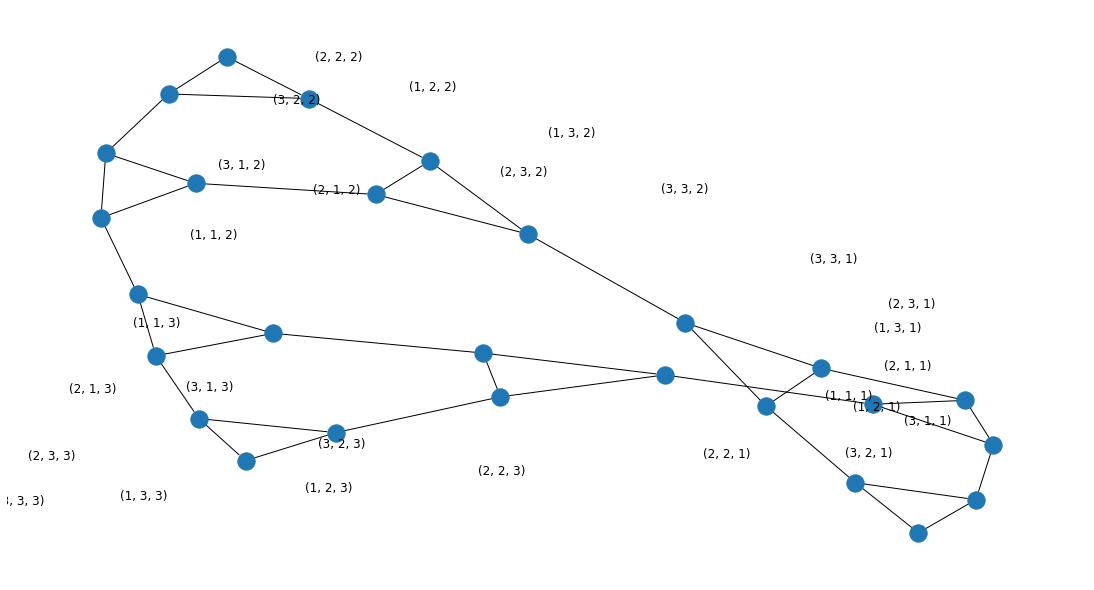

In [3]:
N = 3 #Number of disks in TOH
if not path.exists("Results/"):
    os.mkdir("Results/")
    
print("\n\n *********************************************************************** ")
print(" TOH with ", N, " disks ")
print("****************************************************************************\n\n")

result_dir_for_N_disks= "Results/"+str(N)+"_disks_Results"
if not path.exists(result_dir_for_N_disks):
    os.mkdir(result_dir_for_N_disks)


print("\n\n-----------------------------------------------------------------------------------------------")
print("STEP 0 - TOH :  Define game variables and rules")
print("-----------------------------------------------------------------------------------------------")

R, R_values, states, moves = generate_reward_matrix(N)

debug = False
if debug :
    print("R.shape : ", R_values.shape)
    print("R : ", R_values)

G = generate_graph_from_reward_matrix(N,R,result_dir_for_N_disks)
toh_dict_grammar = generate_grammar_from_df(N, R, G,result_dir_for_N_disks)

In [4]:
R.shape
R.describe()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


,"(1, 1, 1)","(1, 1, 2)","(1, 1, 3)","(1, 2, 1)","(1, 2, 2)","(1, 2, 3)","(1, 3, 1)","(1, 3, 2)","(1, 3, 3)","(2, 1, 1)",...,"(2, 3, 3)","(3, 1, 1)","(3, 1, 2)","(3, 1, 3)","(3, 2, 1)","(3, 2, 2)","(3, 2, 3)","(3, 3, 1)","(3, 3, 2)","(3, 3, 3)"
count,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,...,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0,27.0
mean,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
25%,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0




-----------------------------------------------------------------------------------------------
STEP 1 - QLEARNING 
-----------------------------------------------------------------------------------------------

STEP 1.a - QLEARNING :  AA LEARNING, PLAYING and being recorded------------------------------- 

List of training episodes :  [0, 1, 2, 5, 10]
 - Learning times :  10
 - Play times :  10
 learn time :  0
 learn time :  1
 learn time :  2
 learn time :  3
 learn time :  4
 learn time :  5
 learn time :  6
 learn time :  7
 learn time :  8
 learn time :  9


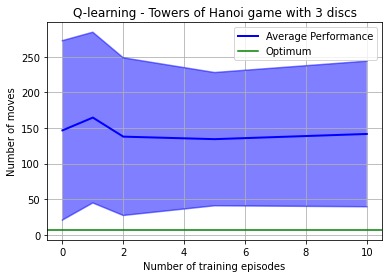

In [5]:
#Advised paramters from the article - Attention to computationnal time and memory consumption
#episodes = [0, 100,300,500,1000]
#learn_times = 100
#play_times=100

#Simple parameters to launch and execute quickly the code
episodes = [0, 1, 2, 5, 10]
learn_times = 10
play_times=10



print("\n\n-----------------------------------------------------------------------------------------------")
print("STEP 1 - QLEARNING ")
print("-----------------------------------------------------------------------------------------------")

print("\nSTEP 1.a - QLEARNING :  AA LEARNING, PLAYING and being recorded------------------------------- \n")

print("List of training episodes : ", episodes)
print(" - Learning times : ", learn_times)
print(" - Play times : ", play_times)

means_averaged, stds_averaged ,seq_states= Q_performance_average(R_values, episodes,learn_times, play_times, debug=False)
plot_Qlearning_average_number_of_moves(N, episodes,means_averaged,stds_averaged, result_dir_for_N_disks)



In [6]:
global_dict={}
dict_sequences_of_moves={}
nb_sequences=0

print("\nSTEP 1.b - QLEARNING :  extraction of sequences of moves to explicit the behavioral patterns------------------------------- \n")

dict_sequences_of_moves_per_training_session={}
for j, N_episodes in enumerate(episodes):
    dict_sequences_of_moves_per_training_session[j]={'nb_training_episodes': N_episodes, 'sequences':[]}

result_dir_Q_learning_step = result_dir_for_N_disks + "/Step1-Q-learning/"
if not path.exists(result_dir_Q_learning_step):
    os.mkdir(result_dir_Q_learning_step)

for n in range(learn_times):
    list_sequences_per_learning_time=[]
    if debug : print("\nlearn_times  n :", n)
    sequences_of_learn_times = seq_states[n]
    dict_session={}
    for j, N_episodes in enumerate(episodes):
        list_sequences_per_learning_time_per_episodes=[]
        if debug : print("\n ==> j :", j, " - N_episodes : ",N_episodes)
        list_sequences_of_episode = sequences_of_learn_times[j]
        if debug : print("==> sequences_of_episode :", list_sequences_of_episode)
        dict_play_time={}

        for i in range(play_times):

            sequence_of_one_play_time= list_sequences_of_episode[i]
            if debug :
                print("\n        play_times i :", i)
                print("        sequence_of_one_play_time : ", len(sequence_of_one_play_time), " - ", sequence_of_one_play_time)
            sequence_of_states = []
            sequence_of_moves=[]

            for z in range(len(sequence_of_one_play_time) - 1):
                a_state=sequence_of_one_play_time[z]
                sequence_of_states.append(states[a_state])
                if debug : print("type(states[a_state]) : ",type(states[a_state]))

                current_state = states[a_state]
                next_state = states[sequence_of_one_play_time[z + 1]]

                diff =""
                for t in range(len(current_state)):
                    if current_state[t]!=next_state[t]:
                        diff=str(current_state[t])+"-"+str(next_state[t])

                if debug : print("current_state: ",current_state, " - next_state : ", next_state, " - diff : ", diff)
                if diff !="" :
                    sequence_of_moves.append(diff)

                if (z+1)==(len(sequence_of_one_play_time) - 1) :
                    sequence_of_states.append(next_state)

            if debug :
                print("        sequence_of_states : ", len(sequence_of_states) , " - ",  sequence_of_states)
                print("        sequence_of_moves : ", len(sequence_of_moves), " - ", sequence_of_moves)

            dict_play_time[i] = {'id_play_time': i, 'sequence_of_move':sequence_of_moves, 'sequence_of_states':sequence_of_states}
            list_sequences_per_learning_time_per_episodes.append(sequence_of_moves)
            nb_sequences+=1

        dict_session[j]={'id_session': j, 'session_data':dict_play_time}



        list_sequences_per_learning_time = list_sequences_per_learning_time_per_episodes + list_sequences_per_learning_time

        #Update dict_sequences_of_moves_per_training_session with these sequences of this id_learn_time
        previous_seqs = dict_sequences_of_moves_per_training_session[j]['sequences']
        previous_seqs= previous_seqs+ list_sequences_per_learning_time_per_episodes
        dict_sequences_of_moves_per_training_session[j]['sequences'] = previous_seqs

    dict_sequences_of_moves[n] = {'id_learn_time': n, 'N_episodes': N_episodes, 'learn_times_data': dict_session}
    if debug : print(" j : ", j, " - N_episodes : ", N_episodes, " - len dict_sequences_of_moves_per_training_session[j]['sequences'] : ", len(dict_sequences_of_moves_per_training_session[j]['sequences']))

print("Saving of a total of ", nb_sequences, " sequences into ",result_dir_Q_learning_step,"dict_sequences_of_moves_per_training_session.json...")
tools.save_dict_in_json(dict_sequences_of_moves_per_training_session, result_dir_Q_learning_step+"dict_sequences_of_moves_per_training_session.json")


STEP 1.b - QLEARNING :  extraction of sequences of moves to explicit the behavioral patterns------------------------------- 

Saving of a total of  500  sequences into  Results/3_disks_Results/Step1-Q-learning/ dict_sequences_of_moves_per_training_session.json...


'Results/3_disks_Results/Step1-Q-learning/dict_sequences_of_moves_per_training_session.json'

In [7]:
for key in sorted(dict_sequences_of_moves_per_training_session.keys()):
    file_name = result_dir_Q_learning_step+"/id_training_sessions_" + str(
        key) + "_sequences_of_moves_"+str(learn_times)+"_learn_times_"+str(play_times)+"_play_times"
    print("==>key ", key," : for id_training_session:", str(key), ", with Nb training episodes :  ",dict_sequences_of_moves_per_training_session[key]["nb_training_episodes"],
          " :  ", len(dict_sequences_of_moves_per_training_session[key]["sequences"]), " sequences are saved in : ",
          file_name)
    np.save(file_name, np.asarray(dict_sequences_of_moves_per_training_session[key]["sequences"]))

global_dict={"learn_times":learn_times, "play_times": play_times, "N_disk":N, "episodes":episodes, "dict_sequences_of_moves_per_training_session":dict_sequences_of_moves_per_training_session}
tools.save_dict_in_json(global_dict,result_dir_Q_learning_step+"/2022-04-21-global_dict_with_dict_sequences_of_moves_per_training_session.json")
print("RESULTS: Global_dict with ",str(N), "disks saved in ",result_dir_Q_learning_step,"/2022-04-21-global_dict_with_dict_sequences_of_moves_per_training_session.json")

global_dict={"learn_times":learn_times, "play_times": play_times, "N_disk":N, "episodes":episodes, "dict_sequences_of_moves":dict_sequences_of_moves}
tools.save_dict_in_json(global_dict,result_dir_Q_learning_step+"/2022-04-21-global_dict.json")
print("RESULTS: Global_dict with ",str(N), "disks saved in ",result_dir_Q_learning_step,"2022-04-21-global_dict.json")

==>key  0  : for id_training_session: 0 , with Nb training episodes :   0  :   100  sequences are saved in :  Results/3_disks_Results/Step1-Q-learning//id_training_sessions_0_sequences_of_moves_10_learn_times_10_play_times
==>key  1  : for id_training_session: 1 , with Nb training episodes :   1  :   100  sequences are saved in :  Results/3_disks_Results/Step1-Q-learning//id_training_sessions_1_sequences_of_moves_10_learn_times_10_play_times
==>key  2  : for id_training_session: 2 , with Nb training episodes :   2  :   100  sequences are saved in :  Results/3_disks_Results/Step1-Q-learning//id_training_sessions_2_sequences_of_moves_10_learn_times_10_play_times
==>key  3  : for id_training_session: 3 , with Nb training episodes :   5  :   100  sequences are saved in :  Results/3_disks_Results/Step1-Q-learning//id_training_sessions_3_sequences_of_moves_10_learn_times_10_play_times
==>key  4  : for id_training_session: 4 , with Nb training episodes :   10  :   100  sequences are saved in 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


RESULTS: Global_dict with  3 disks saved in  Results/3_disks_Results/Step1-Q-learning/ /2022-04-21-global_dict_with_dict_sequences_of_moves_per_training_session.json
RESULTS: Global_dict with  3 disks saved in  Results/3_disks_Results/Step1-Q-learning/ 2022-04-21-global_dict.json


## STEP 2 - Train the LSTM RNN with TOH sequences

The Moves Sequence Learning Phase consists in training an RNN with LSTM units (named from here as the LSTM model) with the recorded sequences of moves of the AA. The model needs to learn to predict the AA’s next move at time t based on the current and past ones. <br/>
This step returns a dataset of recordings of hidden patterns (i.e, the activity vectors of the hidden layer generated by the network at each input). <br/>
The trained LSTM model had encoded an implicit representation of the TOH rules due to the learned sequences. 
Let us note that the trained LSTM model is trained on sequences generated from the TOH grammar. <br/>

In [8]:
from tohgrammar import TohGrammar


print("\n\n-----------------------------------------------------------------------------------------------")
print("STEP 2 - RNN-LSTM : Encoding implicit TOH rules representation through learning ")
print("-----------------------------------------------------------------------------------------------")


# NEXT STEP :
# use toh_grammar to generate sequences to train the LSTM network
result_dir_RNN_LSTM_step = result_dir_for_N_disks + "/Step2-RNN_LSTM/"
if not path.exists(result_dir_RNN_LSTM_step):
    os.mkdir(result_dir_RNN_LSTM_step)
    
debug= False
transitions=[]

if debug : print("toh_dict_grammar.keys() : ", toh_dict_grammar.keys())
for k in sorted(toh_dict_grammar.keys(), key=int):
    state = toh_dict_grammar[k]["label"]
    transitions_tuples= toh_dict_grammar[k]["transitions"]
    for tuple in transitions_tuples :
        if tuple[0] not in transitions :
            transitions.append(tuple[0])

print ("Number of transitions in hanoi grammar : ", len(transitions))
print (transitions)


if debug : print( "toh_dict_grammar.keys() : ", toh_dict_grammar.keys())
hanoi_grammar = TohGrammar(transitions, toh_dict_grammar)
TOH_dataset = hanoi_grammar.create_sequences_hanoi(10)

file_name = result_dir_RNN_LSTM_step+"TOH_dataset_" + str(len(TOH_dataset)) + "_sequences_"+ str(N) + "_disks"
print("TOH dataset of :", str(len(TOH_dataset)),  " sequences with TOH of", str(N),", disks saved in : ", file_name, ".npy")
np.save(file_name, np.asarray(TOH_dataset))

transition_dict = hanoi_grammar.get_symbols_dict()

print ("Number of transitions in TOH grammar : ", len(transition_dict))
for k, v in transition_dict.items():
    print(k, " : ", v)

print("\n STEP 2.a STEP 2 - RNN-LSTM :Loading TOH grammar and generation of sequences --------------------------\n")

parameters_json_file = "rnn_lstm_model_parameters.json"
print("Loading parameters for the RNN-LSTM step from the following file : ", parameters_json_file)

dict_of_rnn_lstm_model_parameters = tools.get_dict_from_json(parameters_json_file)

nb_sequences = dict_of_rnn_lstm_model_parameters["nb_sequences"]
keras_model_rnn_backup_file = dict_of_rnn_lstm_model_parameters["keras_model_rnn_backup_file"]

nb_hidden_layer = dict_of_rnn_lstm_model_parameters["nb_hidden_layer"]
nb_LSTM_cell_per_hidden_layer = dict_of_rnn_lstm_model_parameters["nb_LSTM_cell_per_hidden_layer"]
epochs = dict_of_rnn_lstm_model_parameters["epochs"]
debug = dict_of_rnn_lstm_model_parameters["debug"]

# files --------------------------------------------
history_losses_png_file = dict_of_rnn_lstm_model_parameters["history_losses_png_file"]
losses_by_epoch_png_file = dict_of_rnn_lstm_model_parameters["losses_by_epoch_png_file"]
accuracy_by_epoch_png_file = dict_of_rnn_lstm_model_parameters["accuracy_by_epoch_png_file"]

rnn_lstm_model_backup_file = dict_of_rnn_lstm_model_parameters["rnn_lstm_model_backup_file"]

#test_sequences_json_file = dict_of_rnn_lstm_model_parameters["test_sequences_json_file"]
#test_predictions_and_HS_json_file = dict_of_rnn_lstm_model_parameters["test_predictions_and_HS_json_file"]
#rnn_weights_file = dict_of_rnn_lstm_model_parameters["rnn_weights_file"]
#rnn_for_hidden_states_LSTM_layer_weights_file = dict_of_rnn_lstm_model_parameters["rnn_for_hidden_states_LSTM_layer_weights_file"]

#analysis_of_artificial_agent_behavior = dict_of_rnn_lstm_model_parameters["analysis_of_artificial_agent_behavior"],
#artificial_agent_behavior_data_set = dict_of_rnn_lstm_model_parameters["artificial_agent_behavior_data_set"]





-----------------------------------------------------------------------------------------------
STEP 2 - RNN-LSTM : Encoding implicit TOH rules representation through learning 
-----------------------------------------------------------------------------------------------
Number of transitions in hanoi grammar :  6
['1-2', '1-3', '2-3', '3-2', '2-1', '3-1']
starting index :  0  - ending index  26
Generation of  10  sequences done !
 --> The average len is :  368.6
 --> The standard deviation is :  254.16341200101954
TOH dataset of : 10  sequences with TOH of 3 , disks saved in :  Results/3_disks_Results/Step2-RNN_LSTM/TOH_dataset_10_sequences_3_disks .npy
Number of transitions in TOH grammar :  8
B  :  [1, 0, 0, 0, 0, 0, 0, 0]
1-2  :  [0, 1, 0, 0, 0, 0, 0, 0]
1-3  :  [0, 0, 1, 0, 0, 0, 0, 0]
2-3  :  [0, 0, 0, 1, 0, 0, 0, 0]
3-2  :  [0, 0, 0, 0, 1, 0, 0, 0]
2-1  :  [0, 0, 0, 0, 0, 1, 0, 0]
3-1  :  [0, 0, 0, 0, 0, 0, 1, 0]
E  :  [0, 0, 0, 0, 0, 0, 0, 1]

 STEP 2.a STEP 2 - RNN-LSTM :Lo

In [9]:
from rnnlstmmodel import RnnLstmModel
from datasetofsequences import DataSetOfSequences

print("\n STEP 2.b  - RNN-LSTM :Training, evaluation and test of the model --------------------------\n")
rnn_lstm_model = RnnLstmModel(transition_dict,nb_LSTM_cell_per_hidden_layer,debug)

TOH_dataset_of_sequences = DataSetOfSequences(TOH_dataset,transition_dict)

#TRAINING of the LSTM model --------------------------
input_train_reshape= TOH_dataset_of_sequences.get_input_train_reshape()
expected_output_train_reshape= TOH_dataset_of_sequences.get_expected_output_train_reshape()
input_train_val_reshape=TOH_dataset_of_sequences.get_input_train_val_reshape()
expected_output_train_val_reshape=TOH_dataset_of_sequences.get_expected_output_train_val_reshape()

if debug : 
    print ("epochs : ", epochs," - input_train_reshape.shape : ",input_train_reshape.shape ," - expected_output_train_reshape.shape : ", expected_output_train_reshape.shape ," - input_train_val_reshape.shape : ", input_train_val_reshape.shape ," - expected_output_train_val_reshape.shape : ", expected_output_train_val_reshape.shape ," - keras_model_rnn_backup_file : ",keras_model_rnn_backup_file)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2

 STEP 2.b  - RNN-LSTM :Training, evaluation and test of the model --------------------------



-----------------------------------------------------------------------------------------------
STEP 5.1' - Create RNN Keras Model
-----------------------------------------------------------------------------------------------
rnn_model :
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 8)]    0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, None, 8



-----------------------------------------------------------------------------------------------
STEP 5.2 - Train RNN Keras Model
-----------------------------------------------------------------------------------------------


 epochs :  10
Epoch 1/10
419/419 [==============================] - 13s 15ms/step - loss: 0.1798 - output_layer_loss: 0.1798 - output_layer_accuracy: 0.1777 - lstm_accuracy: 0.1721 - lstm_1_accuracy: 0.1503 - val_loss: 0.1073 - val_output_layer_loss: 0.1073 - val_output_layer_accuracy: 0.2468 - val_lstm_accuracy: 0.2143 - val_lstm_1_accuracy: 0.2143
Epoch 2/10
419/419 [==============================] - 4s 10ms/step - loss: 0.1063 - output_layer_loss: 0.1063 - output_layer_accuracy: 0.2796 - lstm_accuracy: 0.1915 - lstm_1_accuracy: 0.1915 - val_loss: 0.1036 - val_output_layer_loss: 0.1036 - val_output_layer_accuracy: 0.3377 - val_lstm_accuracy: 0.2143 - val_lstm_1_accuracy: 0.2143
Epoch 3/10
419/419 [==============================] - 4s 10ms/step - loss: 0.1037 

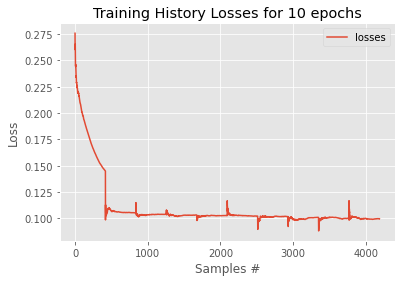

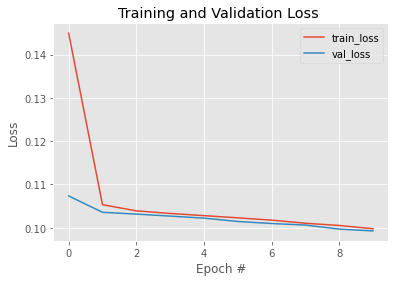

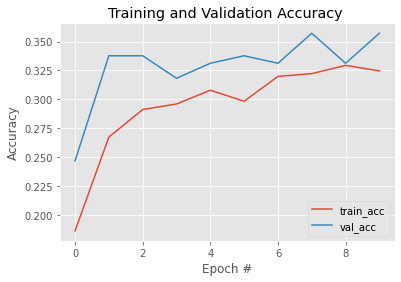

In [10]:
rnn_lstm_model.train_model(epochs,input_train_reshape,expected_output_train_reshape,input_train_val_reshape,expected_output_train_val_reshape,
                           rnn_lstm_model_backup_file, history_losses_png_file, losses_by_epoch_png_file, accuracy_by_epoch_png_file, 
                           result_dir_RNN_LSTM_step)


In [11]:
input_test_reshape= TOH_dataset_of_sequences.get_input_test_reshape()
expected_output_test_reshape= TOH_dataset_of_sequences.get_expected_output_test_reshape()
rnn_lstm_model.evaluate_model (input_test_reshape, expected_output_test_reshape,input_train_reshape ,expected_output_train_reshape)




-----------------------------------------------------------------------------------------------
STEP 6 - Evaluate training for RNN Keras Model for test dataset
-----------------------------------------------------------------------------------------------

353/353 [==============================] - 2s 5ms/step - loss: 0.1009 - output_layer_loss: 0.1009 - output_layer_accuracy: 0.2890 - lstm_accuracy: 0.1671 - lstm_1_accuracy: 0.1671
     RNN evaluation (test seq)      - Average [loss, accuracy] :  [0.1009446308016777, 0.1009446308016777, 0.2889518439769745, 0.16713881492614746, 0.16713881492614746]
419/419 [==============================] - 2s 5ms/step - loss: 0.0991 - output_layer_loss: 0.0991 - output_layer_accuracy: 0.3556 - lstm_accuracy: 0.1933 - lstm_1_accuracy: 0.1933
     RNN evaluation (train seq)     - Average [loss, accuracy] :  [0.09913543611764908, 0.09913543611764908, 0.35560858249664307, 0.19331742823123932, 0.19331742823123932]


In [12]:
#TESTING the LSTM model ------------------------------
RNN_LSTM_dict_of_extracted_patterns= TOH_dataset_of_sequences.get_dict_of_extracted_patterns()
rnn_lstm_model.test_model(result_dir_RNN_LSTM_step,input_test_reshape,transition_dict,RNN_LSTM_dict_of_extracted_patterns)




-----------------------------------------------------------------------------------------------
STEP 7 - RNN Keras Model predictions for test dataset
-----------------------------------------------------------------------------------------------


     Nb predictions for test dataset:  353
Size of the initialed dictionnary :  353

Saving data for rules extraction (CEC, lstm_outputs and rnn_outputs) in file:  Results/3_disks_Results/Step2-RNN_LSTM/dict_of_extracted_patterns.json


(array([[[0.01543015, 0.25075334, 0.22136244, ..., 0.18391523,
          0.16839975, 0.02675205]],
 
        [[0.01028791, 0.14392117, 0.21302152, ..., 0.29046732,
          0.1411146 , 0.02171668]],
 
        [[0.00647652, 0.23819274, 0.20398775, ..., 0.11710852,
          0.13303179, 0.01483771]],
 
        ...,
 
        [[0.01043621, 0.16729525, 0.22284287, ..., 0.23604926,
          0.12282607, 0.01834965]],
 
        [[0.0086402 , 0.20478904, 0.13095933, ..., 0.20674261,
          0.21187726, 0.02082014]],
 
        [[0.01133057, 0.24760973, 0.1840528 , ..., 0.1534374 ,
          0.17995003, 0.02076551]]], dtype=float32),
 array([[ 0.2512169 , -0.3040274 ,  0.47041246, ...,  0.5694766 ,
         -0.20858836,  0.41067988],
        [ 0.2263308 , -0.28611636,  0.5679432 , ...,  0.5707678 ,
         -0.13596666,  0.49984163],
        [ 0.34086978, -0.3693655 ,  0.5056695 , ...,  0.64675754,
         -0.28687   ,  0.47439304],
        ...,
        [ 0.2335406 , -0.29868358,  0.5510997

## STEP 3 - eXplainable process to explain the  knowledge construction and evolution of Qlearning Agent

The XAI Phase consist in a post-hoc implicit rule extraction algorithm and a graph visualization technique that are applied to the dataset of recorded hidden patterns to extract graphs of AA behavior at different stages of training.



-----------------------------------------------------------------------------------------------
STEP 3 - XAI : Loading XAI parameters and extraction of THE HIDDEN REPRESENTATIONS from RNN LSTM USING sequences from AA playing
---------------------------------------------------------------------------------------------------
Loading parameters for the XAI step from the following file :  xai_hanoi.json
Parameters for rule extraction algorithms are : 
clustering_range_min :  5
clustering_range_max :  7
nb_patterns :  1000


 dict_sequences_of_moves_per_training_session---------

 Analysis of training sesion id :  0

 STEP 3.a - XAI : Transform sequences of AA behavior into samples --------------------------

Number of sequences:  100

Total AA_input_test samples          :  14564
Total expected_output_test samples:  14564
Number of sequences to analyze :  100
Size of the initialized dictionary :  14564

 STEP 3.b - XAI : Reshape data for Keras Model--------------------------


Reshape te

/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_0/Graphs/fsm_short_labels_kmeans_5.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_0/Graphs/fsm_short_labels_kmeans_5.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...

FSM dict saved in json file: Results/3_disks_Results/Step3-XAI/N_episode_0/Graphs/fsm_kmeans_6.json

 create_fsm_object_from_dict long label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_0/Graphs/fsm_long_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_0/Graphs/fsm_long_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_0/Graphs/fsm_short_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_0/Graphs/fsm_short_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...

 Analysis of training sesion id :  1

 STEP 3.a - XAI : Transform sequences of AA behavior into samples --------------------------

Number of sequences:  100

Total AA_input_test samples          :  16359
Total expected_output_test samples:  16359
Number of sequences to analyze :  100
Size of the initialized dictionary :  16359

 STEP 3.b - XAI : Reshape data for Keras Model--------------------------


Reshape test data ...

 STEP 3.c - XAI : Evaluate training for RNN Keras Model for test dataset--------------------------

16359/16359 [==============================] - 59s 4ms/step - loss: 0.1002 - output_layer_loss: 0.1002 - output_layer_accuracy: 0.3124 - lstm_accuracy: 0.1701 - lstm_1_accuracy: 0.1701
     RNN evaluation (test seq)      - Average [loss, accuracy] :  [0.10021720081567764, 0.10021720081567764, 0.3124274015426636, 0.17005929350852966, 0.17005929350852966]

 STEP 3.d - XAI : RNN Ker

/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_1/Graphs/fsm_short_labels_kmeans_5.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_1/Graphs/fsm_short_labels_kmeans_5.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...

FSM dict saved in json file: Results/3_disks_Results/Step3-XAI/N_episode_1/Graphs/fsm_kmeans_6.json

 create_fsm_object_from_dict long label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_1/Graphs/fsm_long_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_1/Graphs/fsm_long_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_1/Graphs/fsm_short_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_1/Graphs/fsm_short_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...

 Analysis of training sesion id :  2

 STEP 3.a - XAI : Transform sequences of AA behavior into samples --------------------------

Number of sequences:  100

Total AA_input_test samples          :  13686
Total expected_output_test samples:  13686
Number of sequences to analyze :  100
Size of the initialized dictionary :  13686

 STEP 3.b - XAI : Reshape data for Keras Model--------------------------


Reshape test data ...

 STEP 3.c - XAI : Evaluate training for RNN Keras Model for test dataset--------------------------

13686/13686 [==============================] - 50s 4ms/step - loss: 0.1001 - output_layer_loss: 0.1001 - output_layer_accuracy: 0.3206 - lstm_accuracy: 0.1694 - lstm_1_accuracy: 0.1694
     RNN evaluation (test seq)      - Average [loss, accuracy] :  [0.10006953030824661, 0.10006953030824661, 0.3206196129322052, 0.16944321990013123, 0.16944321990013123]

 STEP 3.d - XAI : RNN Ker

/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_2/Graphs/fsm_short_labels_kmeans_5.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_2/Graphs/fsm_short_labels_kmeans_5.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...

FSM dict saved in json file: Results/3_disks_Results/Step3-XAI/N_episode_2/Graphs/fsm_kmeans_6.json

 create_fsm_object_from_dict long label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_2/Graphs/fsm_long_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_2/Graphs/fsm_long_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_2/Graphs/fsm_short_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_2/Graphs/fsm_short_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...

 Analysis of training sesion id :  3

 STEP 3.a - XAI : Transform sequences of AA behavior into samples --------------------------

Number of sequences:  100

Total AA_input_test samples          :  13334
Total expected_output_test samples:  13334
Number of sequences to analyze :  100
Size of the initialized dictionary :  13334

 STEP 3.b - XAI : Reshape data for Keras Model--------------------------


Reshape test data ...

 STEP 3.c - XAI : Evaluate training for RNN Keras Model for test dataset--------------------------

13334/13334 [==============================] - 48s 4ms/step - loss: 0.1003 - output_layer_loss: 0.1003 - output_layer_accuracy: 0.3123 - lstm_accuracy: 0.1697 - lstm_1_accuracy: 0.1697
     RNN evaluation (test seq)      - Average [loss, accuracy] :  [0.10030645877122879, 0.10030645877122879, 0.312284380197525, 0.1697165071964264, 0.1697165071964264]

 STEP 3.d - XAI : RNN Keras 

/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_3/Graphs/fsm_short_labels_kmeans_5.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_3/Graphs/fsm_short_labels_kmeans_5.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:621: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots()
/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...

FSM dict saved in json file: Results/3_disks_Results/Step3-XAI/N_episode_3/Graphs/fsm_kmeans_6.json

 create_fsm_object_from_dict long label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_3/Graphs/fsm_long_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_3/Graphs/fsm_long_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_3/Graphs/fsm_short_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_3/Graphs/fsm_short_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...

 Analysis of training sesion id :  4

 STEP 3.a - XAI : Transform sequences of AA behavior into samples --------------------------

Number of sequences:  100

Total AA_input_test samples          :  14062
Total expected_output_test samples:  14062
Number of sequences to analyze :  100
Size of the initialized dictionary :  14062

 STEP 3.b - XAI : Reshape data for Keras Model--------------------------


Reshape test data ...

 STEP 3.c - XAI : Evaluate training for RNN Keras Model for test dataset--------------------------

14062/14062 [==============================] - 51s 4ms/step - loss: 0.1001 - output_layer_loss: 0.1001 - output_layer_accuracy: 0.3197 - lstm_accuracy: 0.1711 - lstm_1_accuracy: 0.1711
     RNN evaluation (test seq)      - Average [loss, accuracy] :  [0.10008157044649124, 0.10008157044649124, 0.31965580582618713, 0.17109940946102142, 0.17109940946102142]

 STEP 3.d - XAI : RNN Ke

/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_4/Graphs/fsm_short_labels_kmeans_5.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_4/Graphs/fsm_short_labels_kmeans_5.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...

FSM dict saved in json file: Results/3_disks_Results/Step3-XAI/N_episode_4/Graphs/fsm_kmeans_6.json

 create_fsm_object_from_dict long label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_4/Graphs/fsm_long_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_4/Graphs/fsm_long_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)



 create_fsm_object_from_dict short label
create files:  Results/3_disks_Results/Step3-XAI/N_episode_4/Graphs/fsm_short_labels_kmeans_6.dot  and  Results/3_disks_Results/Step3-XAI/N_episode_4/Graphs/fsm_short_labels_kmeans_6.png


 Generation of fsm using heat map to display the transition according their weight...


/Users/ichraibi/Documents/BitBucket/DevPostThese/hanoi-interpretability/jupyter_notebook/tools.py:639: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = plt.colorbar(heatmap)




 Generation of fsm using heat map to display the transition according their weight...


NameError: name 'timedelta' is not defined

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

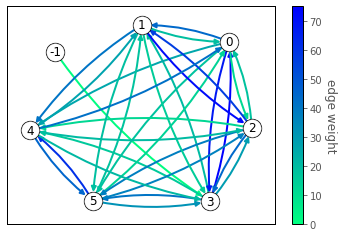

In [13]:
import time
import tensorflow as tf
from datetime import timedelta


print("\n\n-----------------------------------------------------------------------------------------------")
print("STEP 3 - XAI : Loading XAI parameters and extraction of THE HIDDEN REPRESENTATIONS from RNN LSTM USING sequences from AA playing")
print("---------------------------------------------------------------------------------------------------")
result_dir_xai_step=result_dir_for_N_disks+"/Step3-XAI/"
if not path.exists(result_dir_xai_step):
    os.mkdir(result_dir_xai_step)

xai_parameters_file = "xai_hanoi.json"
print("Loading parameters for the XAI step from the following file : ", xai_parameters_file)
parameters_dict = tools.get_dict_from_json(xai_parameters_file)

clustering_range_min = parameters_dict["clustering_range_min"]
clustering_range_max = parameters_dict["clustering_range_max"]
debug = parameters_dict["debug"]
nb_patterns = parameters_dict["nb_patterns"] #number of patterns you want to extract and explain. If equals to 0, the code will analyze all the recorded patterns


assert (clustering_range_max > clustering_range_min)

print("Parameters for rule extraction algorithms are : ")
print("clustering_range_min : ", clustering_range_min)
print("clustering_range_max : ", clustering_range_max)
print("nb_patterns : ", nb_patterns)

start_time = time.monotonic()
print("\n\n dict_sequences_of_moves_per_training_session---------")
for id_training_session,v in dict_sequences_of_moves_per_training_session.items():
    nb_training_episodes= dict_sequences_of_moves_per_training_session[id_training_session]["nb_training_episodes"]
    print("\n Analysis of training sesion id : ", id_training_session)  # ," - v:  ", v)

    result_dir_id_session = result_dir_xai_step+"N_episode_"+str(id_training_session)+"/"
    if not path.exists(result_dir_id_session):
        os.mkdir(result_dir_id_session)

    print("\n STEP 3.a - XAI : Transform sequences of AA behavior into samples --------------------------\n")

    AA_sequences = dict_sequences_of_moves_per_training_session[id_training_session]["sequences"]

    [AA_input_test, AA_expected_output_test, AA_dict_for_test] = tools.transform_sequences_into_data_for_rnn(transition_dict,
                                                                                                    AA_sequences,
                                                                                                    True, debug)
    print("\nTotal AA_input_test samples          : ", len(AA_input_test))
    print("Total expected_output_test samples: ", len(AA_expected_output_test))

    dict_of_extracted_patterns = tools.initialize_dict_of_extracted_patterns(AA_sequences, debug)
    if debug :
        print("dict_of_extracted_patterns : ", len(dict_of_extracted_patterns))
        print("dict_of_extracted_patterns.keys() : ", len(dict_of_extracted_patterns.keys()))
        print("dict_of_extracted_patterns : ", len(dict_of_extracted_patterns))
        print(dict_of_extracted_patterns[0])

    print("\n STEP 3.b - XAI : Reshape data for Keras Model--------------------------\n")

    AA_input_test = np.asarray(AA_input_test)
    AA_expected_output_test = np.asarray(AA_expected_output_test)

    AA_input_test_reshape = np.reshape(AA_input_test, (AA_input_test.shape[0], 1, AA_input_test.shape[1]))
    AA_expected_output_test_reshape = np.reshape(AA_expected_output_test,
                                              (AA_expected_output_test.shape[0], 1, AA_expected_output_test.shape[1]))

    print("\nReshape test data ...")

    if debug:
        print("\nAA_input_test_reshape.shape: ", AA_input_test_reshape.shape)
        print("input_test_reshape: ", AA_input_test_reshape)
        print("\n---------------")
        print("\nexpected_output_test_reshape.shape: ", AA_expected_output_test_reshape.shape)
        print("expected_output_test_reshape: ", AA_expected_output_test_reshape)

    print("\n STEP 3.c - XAI : Evaluate training for RNN Keras Model for test dataset--------------------------\n")


    rnn_model = rnn_lstm_model.get_rnn_model()
    results = rnn_model.evaluate(AA_input_test_reshape, AA_expected_output_test_reshape, batch_size=1, verbose=1)
    print("     RNN evaluation (test seq)      - Average [loss, accuracy] : ", results)

    print("\n STEP 3.d - XAI : RNN Keras Model predictions for test dataset--------------------------\n")

    AA_input_test_reshape = tf.cast(AA_input_test_reshape, tf.float32)

    model_predictions, hidden_pattern_h, states_c = rnn_model.predict(AA_input_test_reshape)

    print("\n     Nb predictions for test dataset: ", len(model_predictions))
    
    if debug: print(len(dict_of_extracted_patterns), " - ",  len(model_predictions), " - ", len(hidden_pattern_h))
    
    dict_of_extracted_patterns = tools.update_dict_of_extracted_patterns(dict_of_extracted_patterns, model_predictions, hidden_pattern_h,
                                                                          result_dir_RNN_LSTM_step + "/dict_of_extracted_patterns.json",
                                                                         transition_dict, debug)
    
    print("Après update dict_of_extracted_patterns : ", len(dict_of_extracted_patterns))
    print("dict_of_extracted_patterns.keys() : ", len(dict_of_extracted_patterns.keys()))
    print("dict_of_extracted_patterns : ", len(dict_of_extracted_patterns))
    print(dict_of_extracted_patterns[0])
    tools.save_dict_in_json(dict_of_extracted_patterns,result_dir_id_session+"dict_of_extracted_patterns.json" )
    print("\n STEP 3.e - XAI : Knowledge Extraction PROCESS through FSA--------------------------\n")

    tools.knowledge_extraction_process(dict_of_extracted_patterns, clustering_range_min, clustering_range_max,
                                       nb_patterns,result_dir_id_session )


end_time = time.monotonic()
print("Execution time for N : ", N," disks --> ", timedelta(seconds=end_time - start_time) ," seconds")
dict_computational_time.update({N:{"execution_time":(end_time - start_time), "optimum_moves":(2 ** N - 1)}})


